## 0. Import Necessary Packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import shutil
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-white')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv


## 1. Import the Dataset

In [2]:
# Read 1M data into memory.
train = pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv', nrows=1000000, index_col=False, delimiter=',', encoding='utf-8')

## 2. Preview the Dataset

In [3]:
# Display the dimensions of the dataset.
rows = train.shape[0]
columns = train.shape[1]
feature_set = train.columns.values
print('Total Number of Features: ', columns)
print('Total Number of Instances: ', rows)
print('Feature Set includes: ', feature_set) 

Total Number of Features:  8
Total Number of Instances:  1000000
Feature Set includes:  ['key' 'fare_amount' 'pickup_datetime' 'pickup_longitude'
 'pickup_latitude' 'dropoff_longitude' 'dropoff_latitude'
 'passenger_count']


In [4]:
# Preview the first 5 instances.
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.500,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1
1,2010-01-05 16:52:16.0000002,16.900,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1
2,2011-08-18 00:35:00.00000049,5.700,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2
3,2012-04-21 04:30:42.0000001,7.700,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1
4,2010-03-09 07:51:00.000000135,5.300,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1


In [5]:
# Display the dimensions and data type of the train data.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
key                  1000000 non-null object
fare_amount          1000000 non-null float64
pickup_datetime      1000000 non-null object
pickup_longitude     1000000 non-null float64
pickup_latitude      1000000 non-null float64
dropoff_longitude    999990 non-null float64
dropoff_latitude     999990 non-null float64
passenger_count      1000000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [6]:
# Return the statistics for all numeric variables.
train.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,1000000.000,11.348,9.822,-44.900,6.000,8.500,12.500,500.000
pickup_longitude,1000000.000,-72.527,12.058,-3377.681,-73.992,-73.982,-73.967,2522.271
pickup_latitude,1000000.000,39.929,7.626,-3116.285,40.735,40.753,40.767,2621.628
dropoff_longitude,999990.000,-72.528,11.324,-3383.297,-73.991,-73.980,-73.964,45.582
dropoff_latitude,999990.000,39.920,8.201,-3114.339,40.734,40.753,40.768,1651.553
passenger_count,1000000.000,1.685,1.324,0.000,1.000,1.000,2.000,208.000


## 3. Feature Engineering

### 3.1 Data Cleaning

From the above statistic summary, it is easy to find that :  
- The minimum fare amount is negative.
- Minimum and Maximum longitude and latitude look unreal.
- Minimum passenger count is 0.

We are going to fix them: 
- New York city latitude and longitude coordinates are: 40.730610, -73.935242.
 - "min_lat": 40.4772,
 - "max_lat": 45.0153,
 - "min_lng": -79.7624,
 - "max_lng": -71.7517
- Remove 0 passenger count.
- The taxi fare is $2.50 initial charge, so we need to remove "fare_amount" smaller than this amount.

In [7]:
train = train[(train['passenger_count']>0) & (train['fare_amount']>=2.50) &  
              ((train['pickup_longitude']>-79.762) & (train['pickup_longitude']<-71.752)) & 
              ((train['pickup_latitude']>40.477) & (train['pickup_latitude']<45.015)) & 
              ((train['dropoff_longitude']>-79.762) & (train['dropoff_longitude']<-71.752)) & 
              ((train['dropoff_latitude']>40.477) & (train['dropoff_latitude']<45.015))]

# Run statistic for narrow data.
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,975637.000,975637.000,975637.000,975637.000,975637.000,975637.000
mean,11.342,-73.975,40.751,-73.974,40.751,1.691
std,9.748,0.041,0.030,0.040,0.033,1.306
min,2.500,-78.669,40.477,-78.669,40.479,1.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000
75%,12.500,-73.968,40.768,-73.965,40.768,2.000
max,500.000,-72.703,43.214,-72.196,44.600,6.000


In [8]:
# Drop 'key' that is useless.
train.drop(columns=['key'], axis=1, inplace=True)

# Check the first 5 rows again.
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.500,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1
1,16.900,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1
2,5.700,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2
3,7.700,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1
4,5.300,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1


## 4. Exploratory Data Analysis (EDA)

### 4.1 Visualize several taxi rides

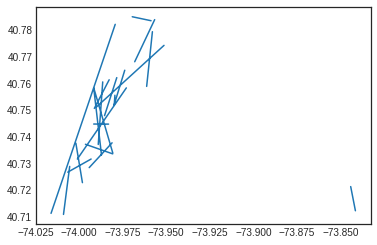

In [9]:
def showRides(df, numlines):
    lats = []
    lons = []
    for iter, row in df[:numlines].iterrows():
        lons.append(row['pickup_longitude'])
        lons.append(row['dropoff_longitude'])
        lons.append(None)
        lats.append(row['pickup_latitude'])
        lats.append(row['dropoff_latitude'])
        lats.append(None)
    
    return lats, lons

lats, lons = showRides(train, 20)
plt.plot(lons, lats)

### 4.2 Fare amount

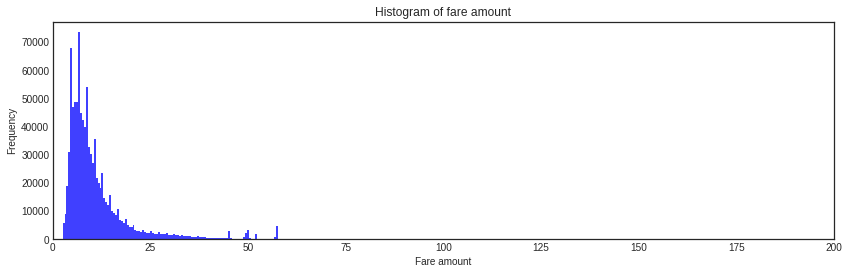

In [10]:
plt.figure(figsize = (14, 4))
# n, bins, patches = plt.hist(train.fare_amount, 1000, facecolor='blue', alpha=0.75)
train['fare_amount'].plot.hist(bins=1000, facecolor='blue', alpha=0.75)
plt.xlabel('Fare amount')
plt.title('Histogram of fare amount')
plt.xlim(0, 200)
plt.show()

The histogram of fare amount shows that most fare amount are very small.

In [11]:
# Show the first 10 largest amount.
train.groupby('fare_amount').size().nlargest(10)

fare_amount
6.500     47487
4.500     40142
8.500     36604
5.300     28483
5.700     28343
6.100     27608
4.900     27505
6.900     25528
10.500    24617
7.300     23834
dtype: int64

The most common fare amount are very small at only 6.5 and 4.5, indicating they were very short rides within Manhattan.

### 4.3 Passenger count

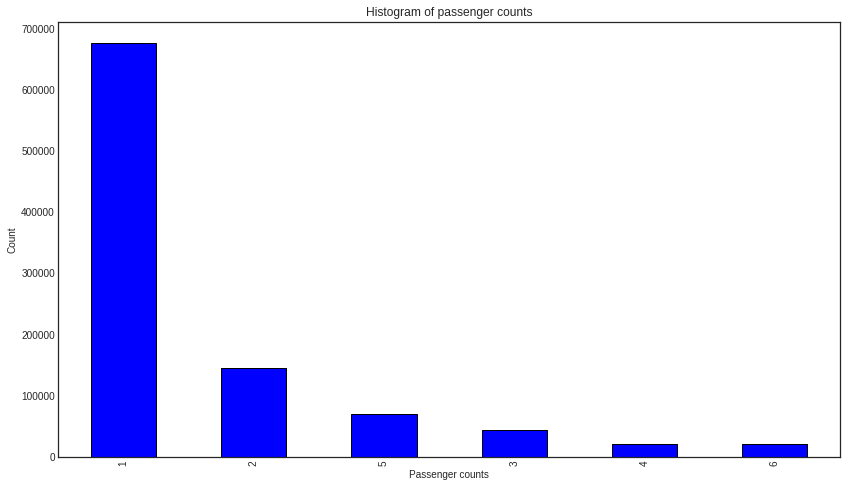

In [12]:
plt.figure(figsize = (14, 8))
train['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k')
plt.xlabel('Passenger counts')
plt.ylabel('Count')
plt.title('Histogram of passenger counts')
plt.show()

In [13]:
# 'passenger_count' distribution.
train.groupby('passenger_count').size()

passenger_count
1    676648
2    145255
3     42870
4     20998
5     69103
6     20763
dtype: int64

Based on the above discovery, we are going to remove taxi rides with `passenger_count`> 6.

In [14]:
train = train.loc[train['passenger_count'] <= 6]

## 5. Define the model

### 5.1 Baseline Model

In [15]:
# train_df, test_df = train_test_split(train, test_size=0.33, random_state=42)

# def distance_between(lat1, lon1, lat2, lon2):
#     # Haversine formula to compute distance
#     dist = np.degrees(np.arccos(np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + 
#                               np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * 
#                                np.cos(np.radians(lon2 - lon1)))) * 60 * 1.515 * 1.609344
#     return dist

# def estimate_distance(df):
#     return distance_between(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

# def compute_rmse(actual, predicted):
#     return np.sqrt(np.mean((actual - predicted)**2))

# def print_rmse(df, rate, name):
#     print("{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate * estimate_distance(df)), name))

# # Calculate the rate that is the mean value between fare and distance.
# rate = train_df['fare_amount'].mean() / estimate_distance(train_df).mean()

# print("Rate = ${0}/km".format(rate))
# print_rmse(train_df, rate, 'Train')
# print_rmse(test_df, rate, 'Test')

### 5.2 Feature Engineering

Extract information from datetime (day of week, month, hour, day). Taxi fares change during different hours of the day and on weekdays/weekends/holidays.

In [16]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['year'] = train.pickup_datetime.dt.year
train['month'] = train.pickup_datetime.dt.month
train['day'] = train.pickup_datetime.dt.day
train['weekday'] = train.pickup_datetime.dt.weekday
train['hour'] = train.pickup_datetime.dt.hour

In [17]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # 6371 is Radius of earth in kilometers. Use 3956 for miles
    return km

# Add one more column 'distance'.
train['distance'] = haversine_np(train['pickup_latitude'], train['pickup_longitude'], train['dropoff_latitude'] , train['dropoff_longitude'])


Add column indicating distance from pick up or drop off coordinates to JFK. Trips from/to JFK have a flat fare at $52.

In [18]:
JFK_coord = (40.6413, -73.7781)

pickup_JFK = haversine_np(train['pickup_latitude'], train['pickup_longitude'], JFK_coord[0], JFK_coord[1]) 
dropoff_JFK = haversine_np(JFK_coord[0], JFK_coord[1], train['dropoff_latitude'], train['dropoff_longitude'])

train['JFK_distance'] = pd.concat([pickup_JFK, dropoff_JFK], axis=1).min(axis=1)

del train['pickup_datetime']

train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour,distance,JFK_distance
0,4.500,-73.844,40.721,-73.842,40.712,1,2009,6,15,0,17,0.410,7.397
1,16.900,-74.016,40.711,-73.979,40.782,1,2010,1,5,1,16,4.629,22.787
2,5.700,-73.983,40.761,-73.991,40.751,2,2011,8,18,3,0,1.001,23.054
3,7.700,-73.987,40.733,-73.992,40.758,1,2012,4,21,5,4,0.910,23.415
4,5.300,-73.968,40.768,-73.957,40.784,1,2010,3,9,1,7,1.361,20.336


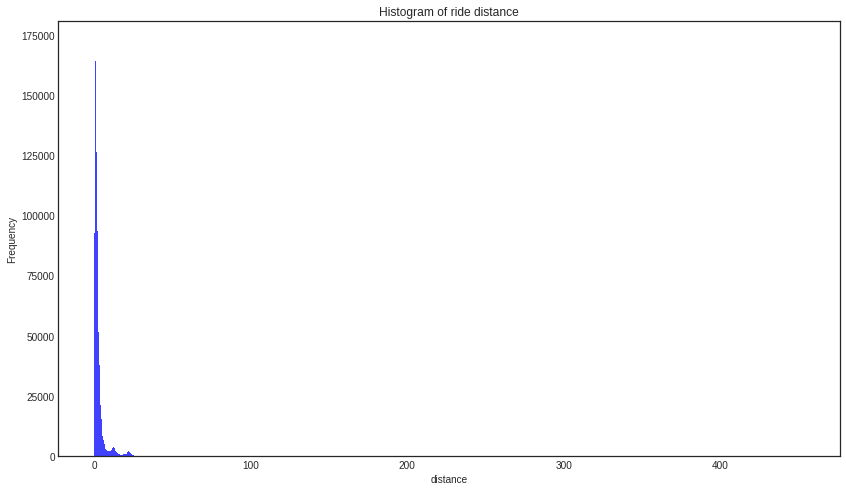

In [19]:
# Visualize the 'distance' feature.
plt.figure(figsize = (14, 8))
# n, bins, patches = plt.hist(taxi.distance, 1000, facecolor='blue', alpha=0.75)
train['distance'].plot.hist(bins=1000, facecolor='blue', alpha=0.75)
plt.xlabel('distance')
plt.title('Histogram of ride distance')
plt.show()

In [20]:
# Check statistic information.
train['distance'].describe()

count   975637.000
mean         2.716
std          4.146
min          0.000
25%          0.854
50%          1.553
75%          2.830
max        453.455
Name: distance, dtype: float64

In [21]:
# Remove all 0 distance.
train = train.loc[train['distance'] > 0]

In [22]:
# Check the final training data again.
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour,distance,JFK_distance
0,4.500,-73.844,40.721,-73.842,40.712,1,2009,6,15,0,17,0.410,7.397
1,16.900,-74.016,40.711,-73.979,40.782,1,2010,1,5,1,16,4.629,22.787
2,5.700,-73.983,40.761,-73.991,40.751,2,2011,8,18,3,0,1.001,23.054
3,7.700,-73.987,40.733,-73.992,40.758,1,2012,4,21,5,4,0.910,23.415
4,5.300,-73.968,40.768,-73.957,40.784,1,2010,3,9,1,7,1.361,20.336


### 5.3 ML Models

In [23]:
# Prepare train and valid dataset.
y = train['fare_amount']
X = train.drop(columns=['fare_amount'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We will benchmark the following models:
- LinearRegression()
- RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
- LinearSVR()

In [24]:
# models = [
#     LinearRegression(),
#     RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100),
#     LinearSVR()
# ]

# def train_model(classifier, X_train, y_train, X_valid, y_valid):
#     # Fit the training data on the classifier.
#     classifier.fit(X_train, y_train)
    
#     # Predict the labels on validation data
#     y_pred = classifier.predict(X_valid)
        
#     return round(mean_squared_error(y_pred, y_valid) ** 0.5, 3)

In [25]:
# for model in models:
#     model_name = model.__class__.__name__
#     rmse = train_model(model, X_train, y_train, X_test, y_test)
#     print("For {0}, the test RMSE = {1}".format(model_name, rmse))   

### 5.4 DL Model

In [26]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)
# 10-fold cross validation.
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X.values, y.values, cv=kfold, n_jobs=1)
print("RMSE:", np.sqrt(results.std()))

RMSE: 1.9227391082979364


## 6. Predict and submit "submission.csv" file

### 6.1 Prepare testing data

In [27]:
# Read test data into memory.
test = pd.read_csv('../input/new-york-city-taxi-fare-prediction/test.csv', index_col=False, delimiter=',', encoding='utf-8')

# Display the dimensions of the dataset.
rows = test.shape[0]
columns = test.shape[1]
feature_set = test.columns.values
print('Total Number of Features: ', columns)
print('Total Number of Instances: ', rows)
print('Feature Set includes: ', feature_set) 

Total Number of Features:  7
Total Number of Instances:  9914
Feature Set includes:  ['key' 'pickup_datetime' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'passenger_count']


In [28]:
# Preview the first 5 instances.
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973,40.764,-73.981,40.744,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.987,40.719,-73.999,40.739,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.983,40.751,-73.980,40.746,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981,40.768,-73.990,40.752,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966,40.790,-73.989,40.744,1


In [29]:
# Prepare testing data.
test_df = test.copy()
test_df.drop(columns=['key'], axis=1, inplace=True)
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])
# test_df = test_df[(test_df['passenger_count']>0) & 
#         ((test_df['pickup_longitude']>-79.762) & (test_df['pickup_longitude']<-71.752)) & 
#         ((test_df['pickup_latitude']>40.477) & (test_df['pickup_latitude']<45.015)) & 
#         ((test_df['dropoff_longitude']>-79.762) & (test_df['dropoff_longitude']<-71.752)) & 
#         ((test_df['dropoff_latitude']>40.477) & (test_df['dropoff_latitude']<45.015))]     
       
# test_df = test_df.loc[test_df['passenger_count'] <= 6]  
    
test_df['year'] = test_df.pickup_datetime.dt.year    
test_df['month'] = test_df.pickup_datetime.dt.month
test_df['day'] = test_df.pickup_datetime.dt.day
test_df['weekday'] = test_df.pickup_datetime.dt.weekday
test_df['hour'] = test_df.pickup_datetime.dt.hour
del test_df['pickup_datetime']        

test_df['distance'] = haversine_np(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                   test_df['dropoff_latitude'], test_df['dropoff_longitude'])
# test_df = test_df.loc[test_df['distance'] > 0]    
pickup_JFK = haversine_np(test_df['pickup_latitude'], test_df['pickup_longitude'], JFK_coord[0], JFK_coord[1]) 
dropoff_JFK = haversine_np(JFK_coord[0], JFK_coord[1], test_df['dropoff_latitude'], test_df['dropoff_longitude'])
test_df['JFK_distance'] = pd.concat([pickup_JFK, dropoff_JFK], axis=1).min(axis=1)
print(test_df.shape)
test_df.head()

(9914, 12)


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour,distance,JFK_distance
0,-73.973,40.764,-73.981,40.744,1,2015,1,27,1,13,1.090,22.035
1,-73.987,40.719,-73.999,40.739,1,2015,1,27,1,13,1.469,23.338
2,-73.983,40.751,-73.980,40.746,1,2011,10,8,5,11,0.356,22.644
3,-73.981,40.768,-73.990,40.752,1,2012,12,1,5,21,1.146,22.915
4,-73.966,40.790,-73.989,40.744,1,2012,12,1,5,21,2.865,21.396


### 6.2 Use DL model on testing data

In [30]:
# predict results
estimator.fit(X, y)
results = estimator.predict(test_df)

submission = pd.DataFrame({'key': test.key, 'fare_amount': results}, columns = ['key', 'fare_amount'])
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,7.573
1,2015-01-27 13:08:24.0000003,8.551
2,2011-10-08 11:53:44.0000002,6.149
3,2012-12-01 21:12:12.0000002,8.185
4,2012-12-01 21:12:12.0000003,11.920


In [31]:
submission.to_csv('submission.csv', index = False)
print(os.listdir('.'))

['submission.csv', '__notebook__.ipynb']
